In [ ]:
# 1. Imports and Setup
import sys
sys.path.append('../')

from src.data.loader import get_equity_data
from src.features.signals import add_rsi, add_sma, add_momentum, add_macd
from src.models.meta_signals import prepare_ml_features, train_meta_model, predict_positions
from src.backtest.simple_backtester import backtest_returns, summarize_performance

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 2. Data Load + Column Cleaning
df = get_equity_data("AAPL", period="1y")

if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0].lower() if col[0] != 'Date' else 'date' for col in df.columns]
else:
    df.columns = [col.lower() for col in df.columns]

/Users/jamespecore/Documents/Github/data_engineering_portfolio_2025/ai-financial-signals-pipeline/notebooks/../src/data/loader.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


In [ ]:
# 3. Add Signals
df = add_rsi(df, 14)
df = add_sma(df, 20)
df = add_momentum(df, 10)
df = add_macd(df)

df['returns'] = df['close'].pct_change() 

In [ ]:
# 4. ML Feature Prep and Model Training
signal_cols = ['rsi_14', 'sma_20', 'momentum_10', 'macd']
X, y = prepare_ml_features(df, signal_cols)

model = train_meta_model(X, y)

              precision    recall  f1-score   support

           0       0.53      0.39      0.45        23
           1       0.53      0.67      0.59        24

    accuracy                           0.53        47
   macro avg       0.53      0.53      0.52        47
weighted avg       0.53      0.53      0.52        47



/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:21:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
# 5. Predict Positions via Meta-Model
df = predict_positions(df, model, signal_cols)
print(df[['date', 'predicted_prob', 'predicted_position']].tail())


          date  predicted_prob  predicted_position
245 2025-07-11        0.566192                   1
246 2025-07-14        0.634933                   1
247 2025-07-15        0.605454                   1
248 2025-07-16        0.217472                  -1
249 2025-07-17        0.072818                  -1


In [13]:
# 6. Backtest Meta-Strategy Returns
df['position'] = df['predicted_position']  # overwrite position for backtest

df = backtest_returns(df)
metrics = summarize_performance(df)
print("Meta-Signal Strategy Performance:", metrics)

Meta-Signal Strategy Performance: {'total_return': 0.36310365329312166, 'sharpe_ratio': 1.157352385009099}


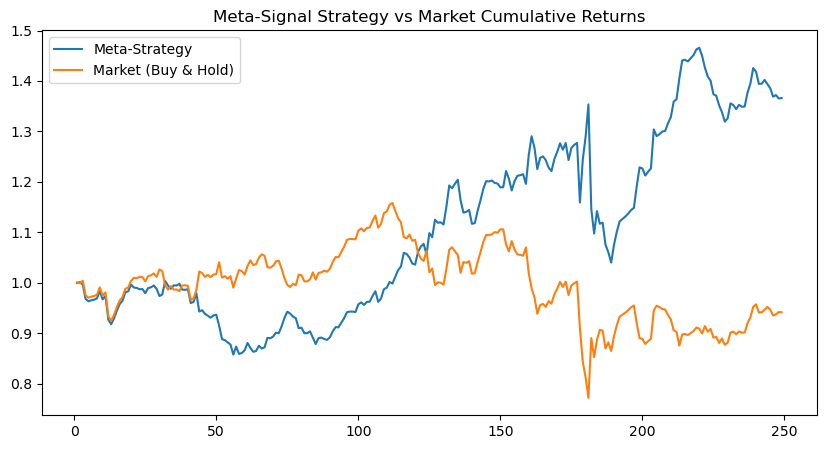

In [14]:
# 7. Cumulative Returns Plot
df['cum_strategy'] = (1 + df['strategy_returns']).cumprod()
df['cum_market'] = (1 + df['returns']).cumprod()

plt.figure(figsize=(10,5))
plt.plot(df['cum_strategy'], label='Meta-Strategy')
plt.plot(df['cum_market'], label='Market (Buy & Hold)')
plt.legend()
plt.title('Meta-Signal Strategy vs Market Cumulative Returns')
plt.show()